In [ ]:
# | default_exp classification.pre_process

In [ ]:
# | export
import numpy as np
import pandas as pd
import torch
from datasetsforecast.m4 import M4
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from tqdm.notebook import tqdm

tqdm.pandas()

In [ ]:
# | hide
import warnings

from statsmodels.tools.sm_exceptions import InterpolationWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=InterpolationWarning)


# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module="scipy.signal._spectral_py")
warnings.filterwarnings("ignore", category=UserWarning, module="scipy")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Suppress InterpolationWarning specifically
warnings.filterwarnings("ignore", category=InterpolationWarning)

In [ ]:
## Prepare data

# Load Labels
label_df = pd.read_parquet("data/evaluation_df.parquet").set_index("unique_id")["best_model"]

# Load M4 dataset
groups = ["Yearly", "Monthly", "Quarterly", "Hourly", "Weekly", "Daily"]
m4_df_bucket = []
for group in groups:
    await M4.async_download("data", group=group)
    Y_df, *_ = M4.load(directory="data", group=group)
    m4_df_bucket.append(Y_df)
m4_dataset = pd.concat(m4_df_bucket)

m4_dataset = m4_dataset.sort_values(["unique_id", "ds"]).drop_duplicates(
    subset=["unique_id", "ds"]
)
no_of_datapoints = m4_dataset.groupby("unique_id").apply(len).to_dict()

# Convert to wide format (fixed)
m4_dataset = m4_dataset.pivot(index="unique_id", columns="ds", values="y")

# # Merge with labels
m4_dataset = m4_dataset.merge(label_df, left_index=True, right_index=True, how="right")

best_model = m4_dataset["best_model"].to_dict()
# df_min = m4_dataset.drop("best_model", axis=1).min(axis=1)
# df_max = m4_dataset.drop("best_model", axis=1).max(axis=1)

# m4_dataset = (m4_dataset.drop("best_model", axis=1) - df_min.values.reshape(-1, 1)) / (
#     df_max - df_min
# ).values.reshape(-1, 1)

m4_dataset["best_model"] = m4_dataset.index.map(best_model)
m4_dataset["no_of_datapoints"] = m4_dataset.index.map(no_of_datapoints)

m4_dataset.sort_values("no_of_datapoints", inplace=True)
# m4_dataset.drop("no_of_datapoints", axis=1, inplace=True)
# # clean up the memory
# del df_max
# del df_min
del m4_df_bucket, no_of_datapoints


m4_dataset.columns = m4_dataset.columns.astype(str)

# # Save as optimized Parquet
m4_dataset.to_parquet("data/m4_preprocessed.parquet", engine="fastparquet", compression="snappy")

print("✅ Preprocessing Complete! Data saved as Parquet.")

/tmp/ipykernel_29138/3507858170.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  no_of_datapoints = m4_dataset.groupby("unique_id").apply(len).to_dict()


✅ Preprocessing Complete! Data saved as Parquet.


In [ ]:
from ts.commons.stats import extract_stats_features

df = pd.read_parquet("data/m4_preprocessed.parquet")
df.drop_duplicates(inplace=True)
X = df.drop(["no_of_datapoints", "best_model"], axis=1)
y = df["best_model"]


# Function to extract features for a single row
def extract_features(idx, name):
    features = extract_stats_features(X.iloc[idx].dropna(), max_lag=10)
    return name, features


# Sequential processing with progress bar
results = [extract_features(idx, name) for idx, name in tqdm(enumerate(X.index), total=len(X))]

# Convert results to DataFrame
df_features = pd.DataFrame(dict(results)).T  # Transpose to get features as columns
# Save to Parquet
df_features.merge(
    df[["best_model", "no_of_datapoints"]], right_index=True, left_index=True, how="left"
).to_parquet("data/extracted_features.parquet", engine="pyarrow")

print("Feature extraction completed and saved to 'extracted_features.parquet")

  0%|          | 0/47752 [00:00<?, ?it/s]

Feature extraction completed and saved to 'extracted_features.parquet


In [ ]:
df = df_features.merge(
    df[["best_model", "no_of_datapoints"]], right_index=True, left_index=True, how="left"
)

<Axes: xlabel='best_model'>

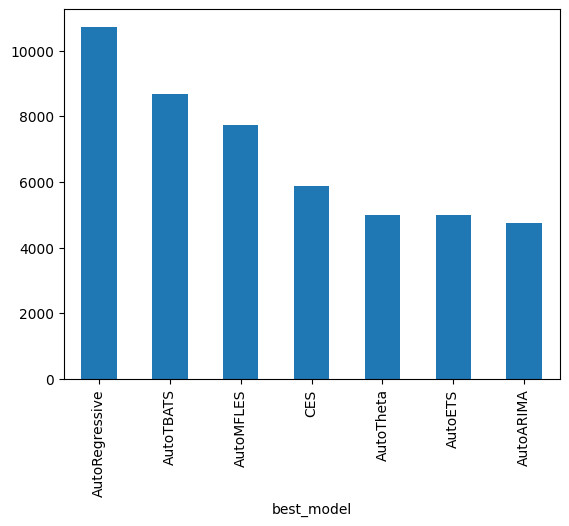

In [ ]:
df.best_model.value_counts().plot(kind="bar")

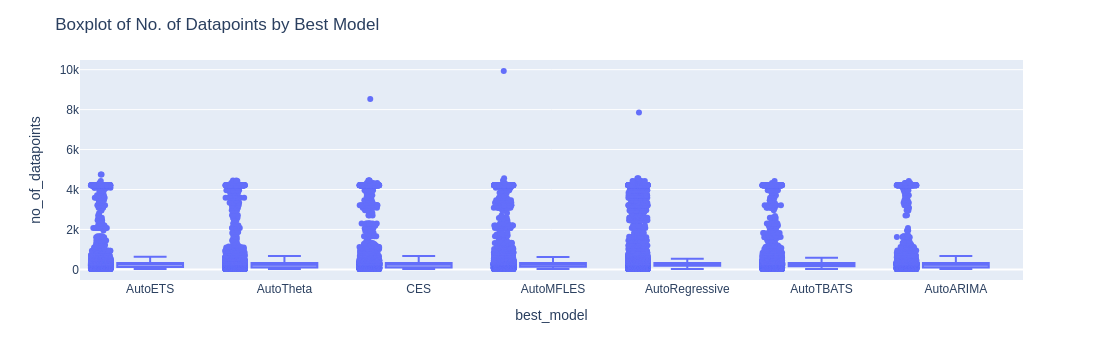

In [ ]:
pip install sweetviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 11.1 MB/s eta 0:00:00m eta 0:00:010:01:01
Note: you may need to restart the kernel to use updated packages.
